# Atividade 4 - Projeto Final

##### Dataset: DeepGlobe Road Extraction Dataset
Link: https://www.kaggle.com/datasets/balraj98/deepglobe-road-extraction-dataset

##### Conectando ao Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Baixando o dataset

In [2]:
!pip install kaggle

!kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset

!unzip deepglobe-road-extraction-dataset.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: train/723199_sat.jpg    
  inflating: train/723226_mask.png   
  inflating: train/723226_sat.jpg    
  inflating: train/723436_mask.png   
  inflating: train/723436_sat.jpg    
  inflating: train/723483_mask.png   
  inflating: train/723483_sat.jpg    
  inflating: train/723622_mask.png   
  inflating: train/723622_sat.jpg    
  inflating: train/723722_mask.png   
  inflating: train/723722_sat.jpg    
  inflating: train/723970_mask.png   
  inflating: train/723970_sat.jpg    
  inflating: train/723990_mask.png   
  inflating: train/723990_sat.jpg    
  inflating: train/724095_mask.png   
  inflating: train/724095_sat.jpg    
  inflating: train/724431_mask.png   
  inflating: train/724431_sat.jpg    
  inflating: train/724485_mask.png   
  inflating: train/724485_sat.jpg    
  inflating: train/724705_mask.png   
  inflating: train/724705_sat.jpg    
  inflating: train/724870_mask.png   
  inflating: train/724870_sat

### BIbliotecas utilizadas  

In [3]:
import os
import sys
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [4]:
!pip install visualkeras
import visualkeras # Para visualizar a estrutura da rede

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 19.6 MB/s eta 0:00:00


### Carregando dados

In [5]:
framObjTrain = {'img' : [],
           'mask' : []
          }

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    maskNames = []

    for mem in imgNames:
        mem = mem.split('_')[0]
        if mem not in maskNames:
            maskNames.append(mem)

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + maskNames[i] + '_sat.jpg')
            mask = plt.imread(maskAddr + maskNames[i] + '_mask.png')

        except:
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:,:,0])

    return frameObj

In [6]:
framObjTrain = LoadData(framObjTrain, imgPath = 'train',
                        maskPath = 'train'
                         , shape = 128)

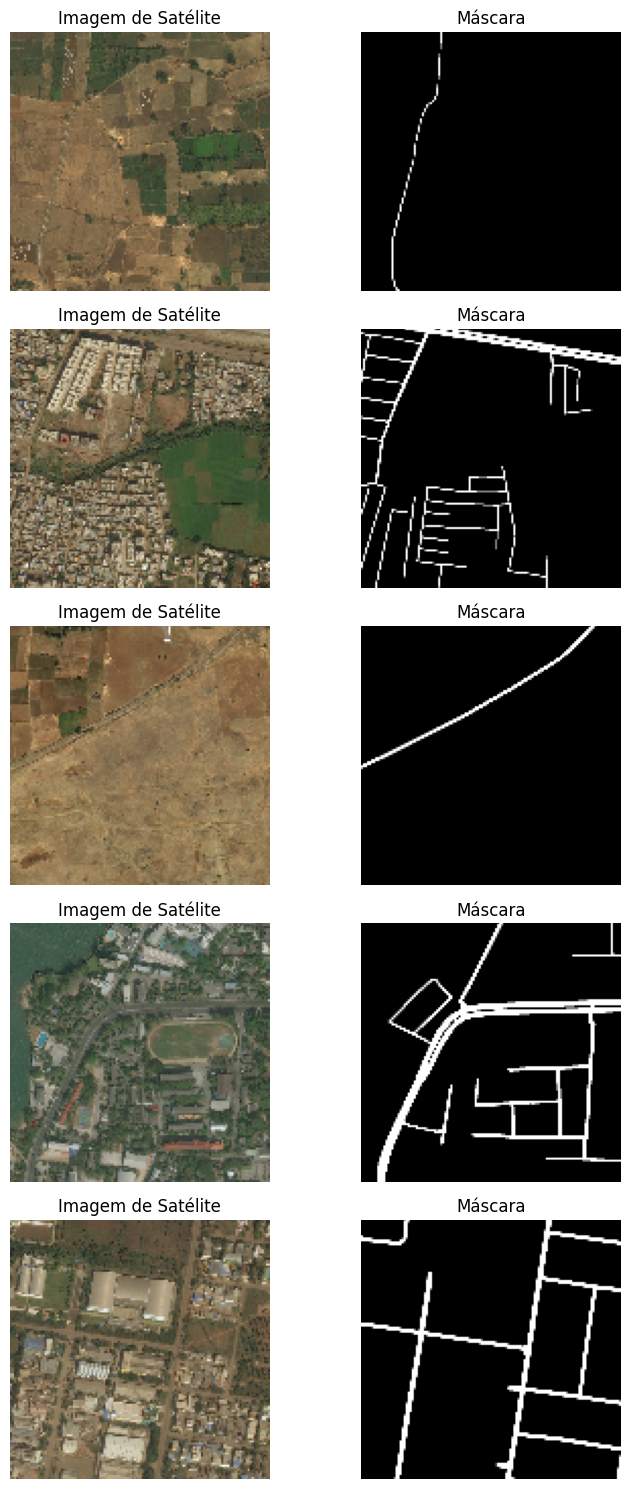

In [7]:
num_pairs = 5
indices = np.random.choice(len(framObjTrain['img']), size=num_pairs, replace=False)
plt.figure(figsize=(8, 15))

for i, idx in enumerate(indices):
    # Subplots para as imagens
    plt.subplot(num_pairs, 2, 2*i + 1)
    plt.imshow(framObjTrain['img'][idx])
    plt.title('Imagem de Satélite')
    plt.axis('off')

    # Subplots para as máscaras
    plt.subplot(num_pairs, 2, 2*i + 2)
    plt.imshow(framObjTrain['mask'][idx], cmap='gray')
    plt.title('Máscara')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Preparando modelo

In [8]:
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    x = tf.keras.layers.Conv2D(filters = numFilters,
                               kernel_size = (kernelSize, kernelSize),
                               kernel_initializer = 'he_normal',
                               padding = 'same') (inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters = numFilters,
                               kernel_size = (kernelSize, kernelSize),
                               kernel_initializer = 'he_normal',
                               padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x

def GiveMeUnet(inputImage, numFilters, droupouts = 0.1, doBatchNorm = True):
    # Encoder
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    # Decoder
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [9]:
# Inicializando modelo
inputs = tf.keras.layers.Input((128, 128, 3)) # Camada de entrada
unet = GiveMeUnet(inputs, numFilters=32, droupouts= 0.07)
unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

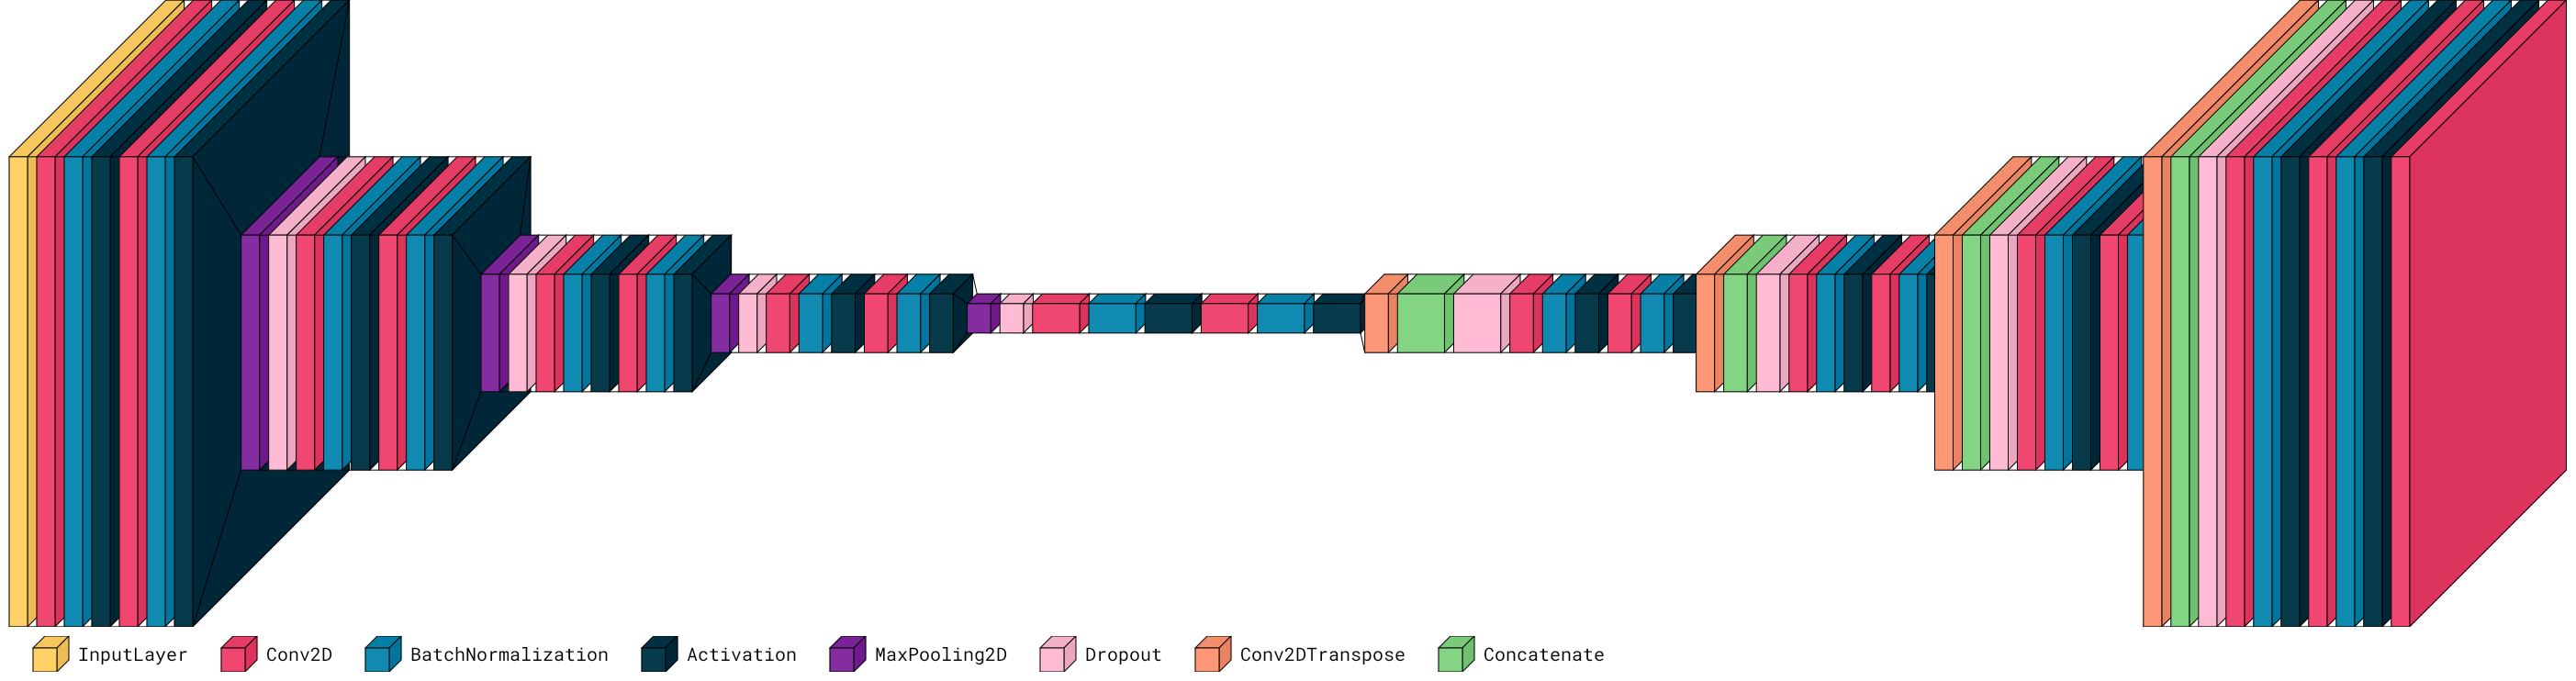

In [62]:
from PIL import ImageFont
font = ImageFont.truetype('/content/drive/MyDrive/RobotoMono.ttf', 20)
visualkeras.layered_view(unet, legend = True, font = font, scale_xy = 4)

In [11]:
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 32)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 32)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 64)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)  

 Total params: 8,642,273 (32.97 MB)

 Trainable params: 8,636,385 (32.95 MB)

 Non-trainable params: 5,888 (23.00 KB)

##### Separando em treino, teste e validação

In [12]:
images = np.array(framObjTrain['img'])
masks = np.array(framObjTrain['mask'])

train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

train_images, test_images, train_masks, test_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)


##### Treinamento

In [13]:
retVal = unet.fit(train_images, train_masks, epochs = 40, verbose = 1, validation_data=(val_images, val_masks))

Epoch 1/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 108s 478ms/step - accuracy: 0.8801 - loss: 0.3651 - val_accuracy: 0.9105 - val_loss: 0.4895
Epoch 2/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 185ms/step - accuracy: 0.9521 - loss: 0.1663 - val_accuracy: 0.9530 - val_loss: 0.1600
Epoch 3/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.9520 - loss: 0.1478 - val_accuracy: 0.9530 - val_loss: 0.1428
Epoch 4/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 189ms/step - accuracy: 0.9538 - loss: 0.1322 - val_accuracy: 0.9534 - val_loss: 0.1472
Epoch 5/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.9554 - loss: 0.1237 - val_accuracy: 0.9543 - val_loss: 0.1302
Epoch 6/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 190ms/step - accuracy: 0.9556 - loss: 0.1193 - val_accuracy: 0.9558 - val_loss: 0.1223
Epoch 7/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 190ms/step - accuracy: 0.9574 - loss: 0.1124 - val_accuracy: 0.9541 - val_loss: 0.1203
Epoch 8/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 188ms/step - accuracy: 0.9581 - loss: 

### Apresentação de métricas

In [14]:
test_eval = unet.evaluate(test_images, test_masks)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9682 - loss: 0.0760
Test loss: 0.07539624720811844
Test accuracy: 0.9684111475944519


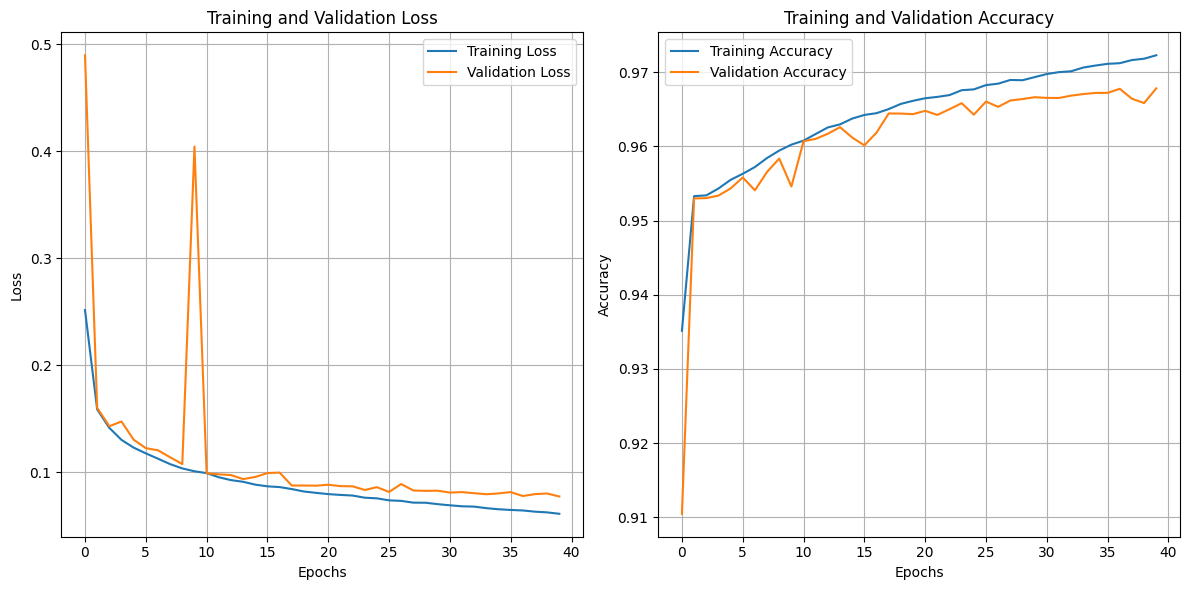

In [15]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(retVal.history['loss'], label='Training Loss')
plt.plot(retVal.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(retVal.history['accuracy'], label='Training Accuracy')
plt.plot(retVal.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Salvando modelo

In [16]:
unet.save('/content/drive/MyDrive/unet_final.h5')

### Carregando modelo treinado

In [ ]:
unet_final = tf.keras.models.load_model('/content/drive/MyDrive/unet_final.h5')

### Testes

In [17]:
def predict16(test_images, test_masks, model, shape=128):
    # Pega 16 imagens aleatórias do conjunto de teste
    indices = np.random.choice(len(test_images), 16, replace=False)
    img_sample = test_images[indices]
    mask_sample = test_masks[indices]

    predictions = model.predict(img_sample)

    predictions = (predictions > 0.4).astype(np.uint8)

    return predictions, img_sample, mask_sample

In [22]:
def Plotter(img, groundTruth, predMask, overlay):
    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title('Imagem de Satélite')
    plt.subplot(1,4,2)
    plt.imshow(groundTruth, cmap='gray')
    plt.title('Rotas Reais')
    plt.subplot(1,4,3)
    plt.imshow(predMask, cmap='gray')
    plt.title('Rotas Previstas')
    plt.subplot(1,4,4)
    plt.imshow(overlay)
    plt.title('Sobreposição')

In [19]:
def create_overlay(image, mask, alpha=0.1):
    mask_rgb = np.repeat(mask, 3, axis=2) * 255  # Máscara branca

    mask_rgb = mask_rgb.astype(np.uint8)
    image = image.astype(np.uint8)

    inverted_mask = 1 - mask

    overlay = image * inverted_mask + mask_rgb
    blended = cv2.addWeighted(image, alpha, overlay.astype(image.dtype), 1 - alpha, 0)

    return blended

In [32]:
sixteenPrediction, actuals, masks = predict16(test_images, test_masks, unet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


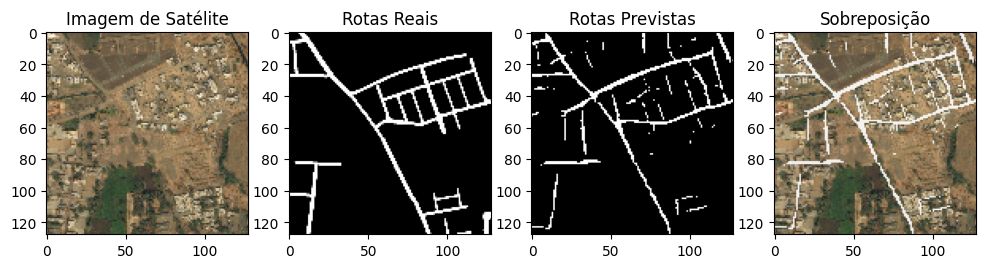

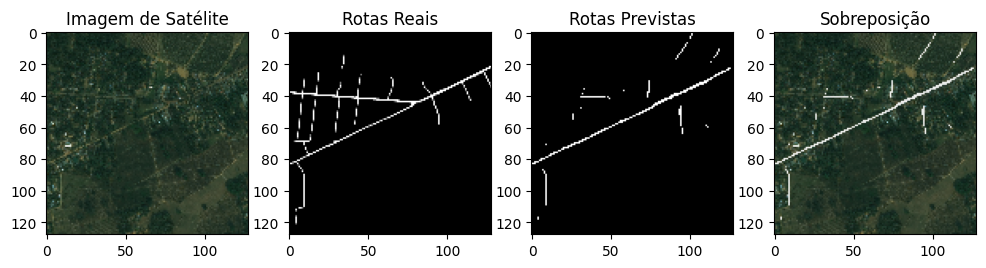

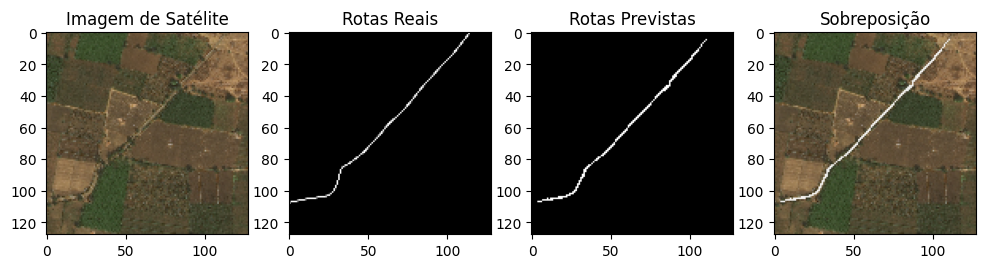

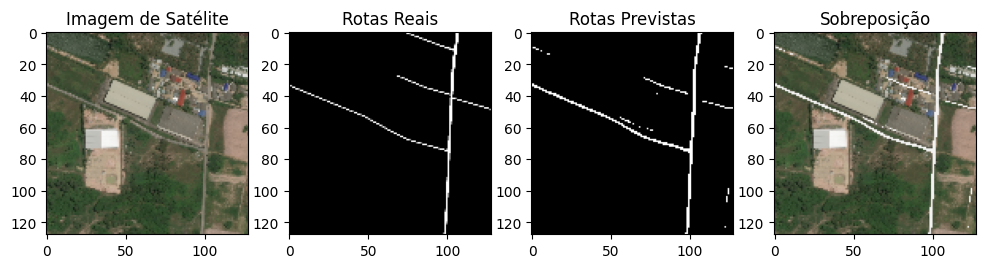

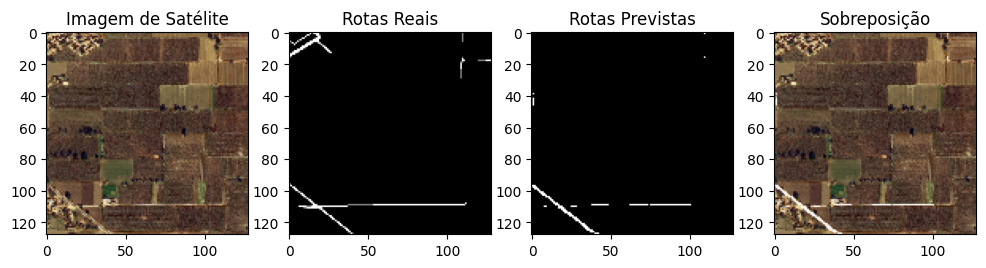

In [33]:
for _ in range(5):
    indice = np.random.randint(0, len(actuals))
    overlay_result = create_overlay(actuals[indice], sixteenPrediction[indice])
    Plotter(actuals[indice], masks[indice], sixteenPrediction[indice][:,:,0], overlay_result)

--------------------------------------------------------------------------------

### Testando com arquivos da pasta 'Teste' do dataset

In [34]:
def LoadTestImages(testImgPath, shape=128):
    testImgNames = os.listdir(testImgPath)
    testImages = []

    for imgName in testImgNames:
        img = plt.imread(os.path.join(testImgPath, imgName))
        img = cv2.resize(img, (shape, shape))
        testImages.append(img)

    return np.array(testImages)

In [40]:
testImgPath = 'test'
testImages = LoadTestImages(testImgPath)
test_predictions = unet.predict(testImages)
test_predictions = (test_predictions > 0.4).astype(np.uint8)

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


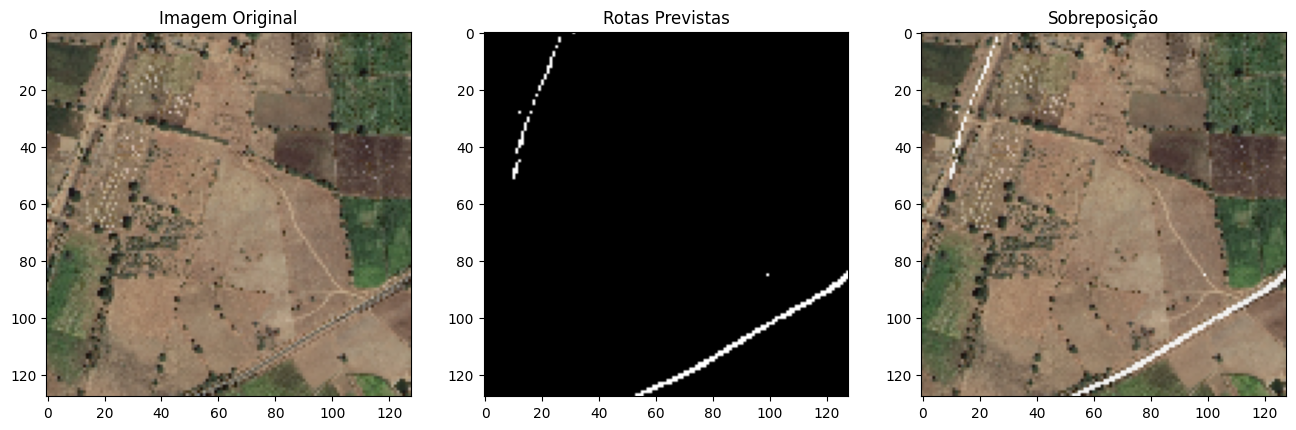

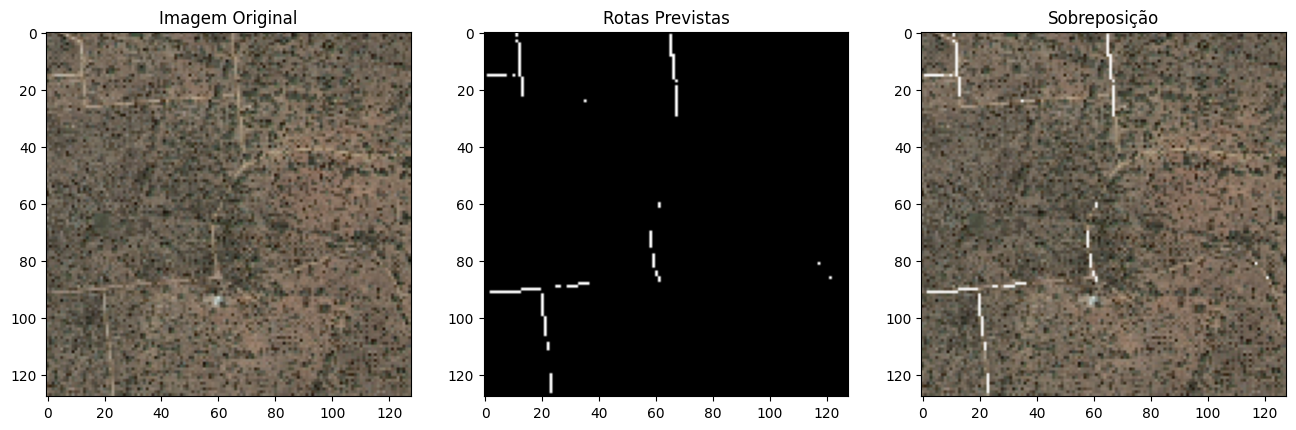

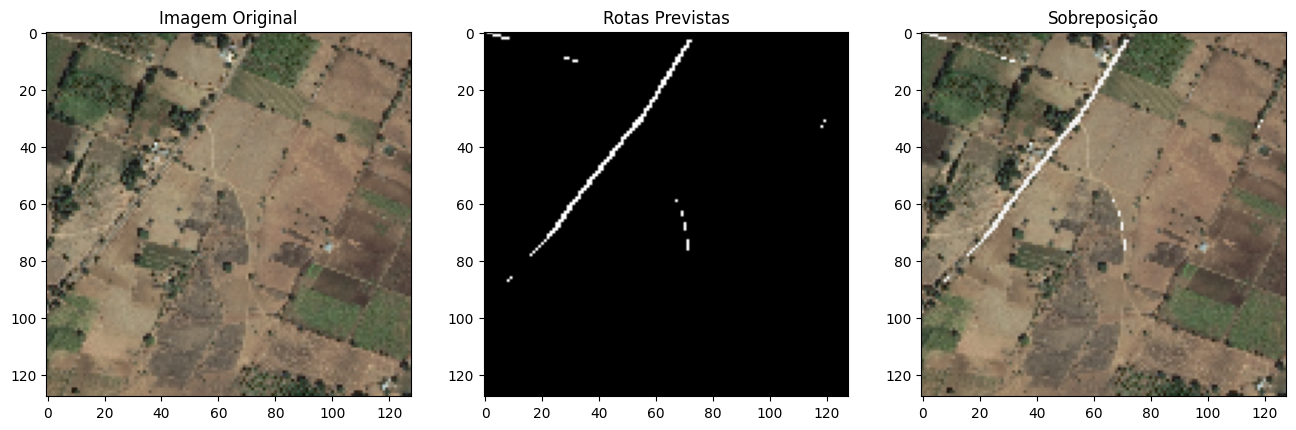

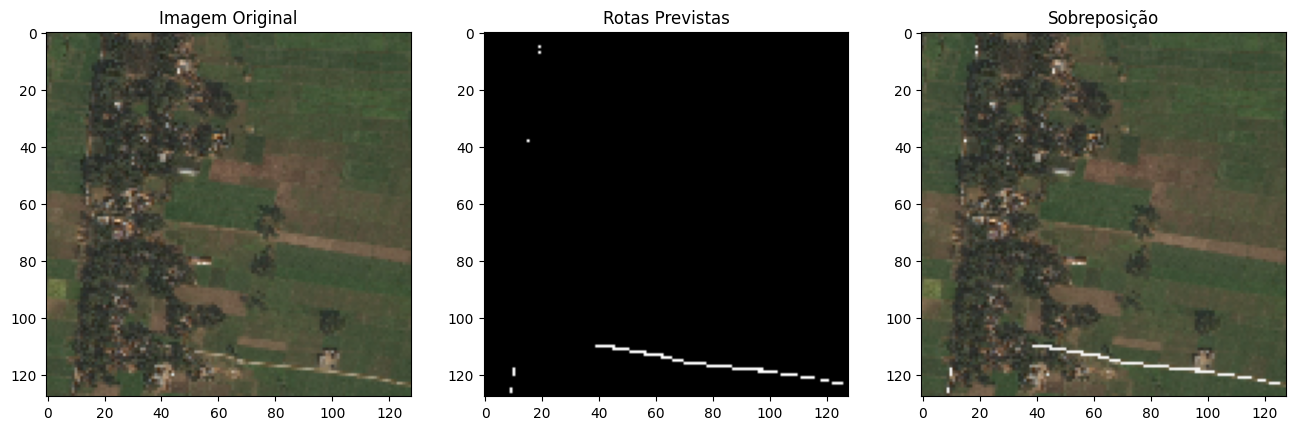

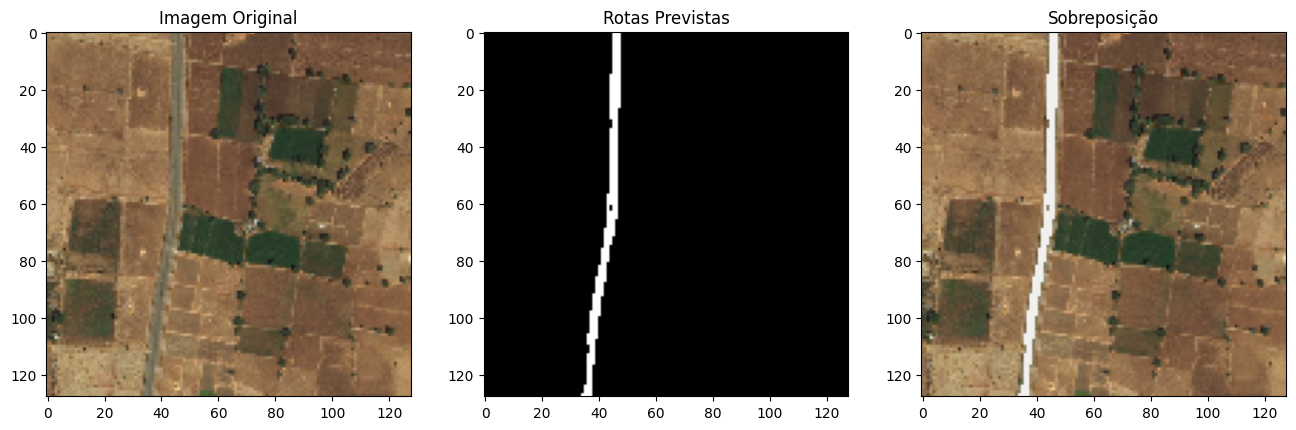

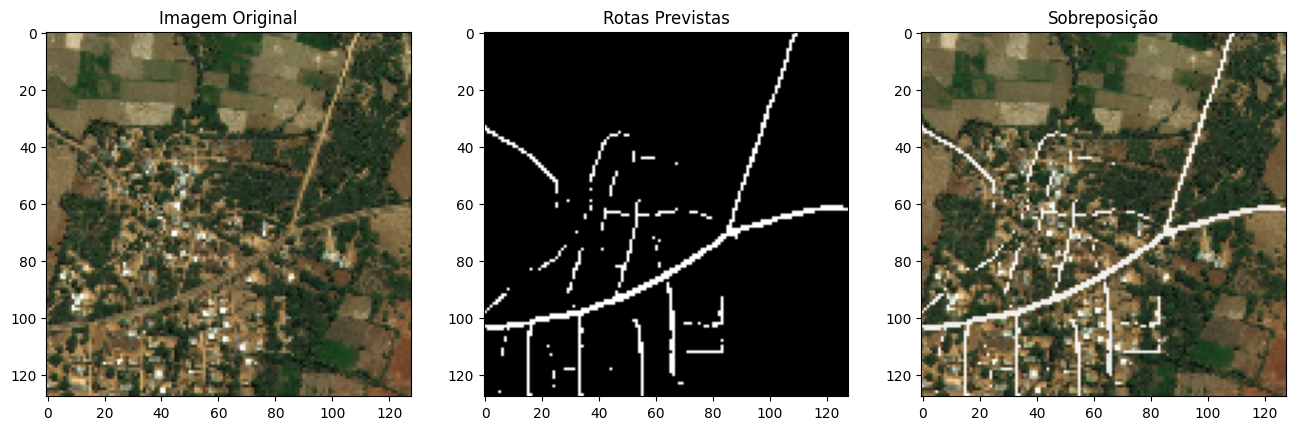

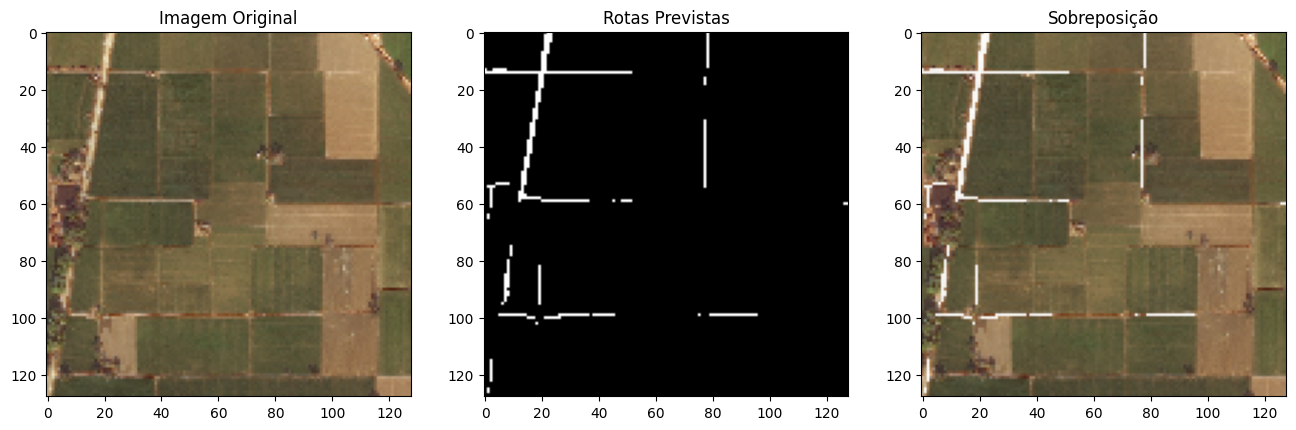

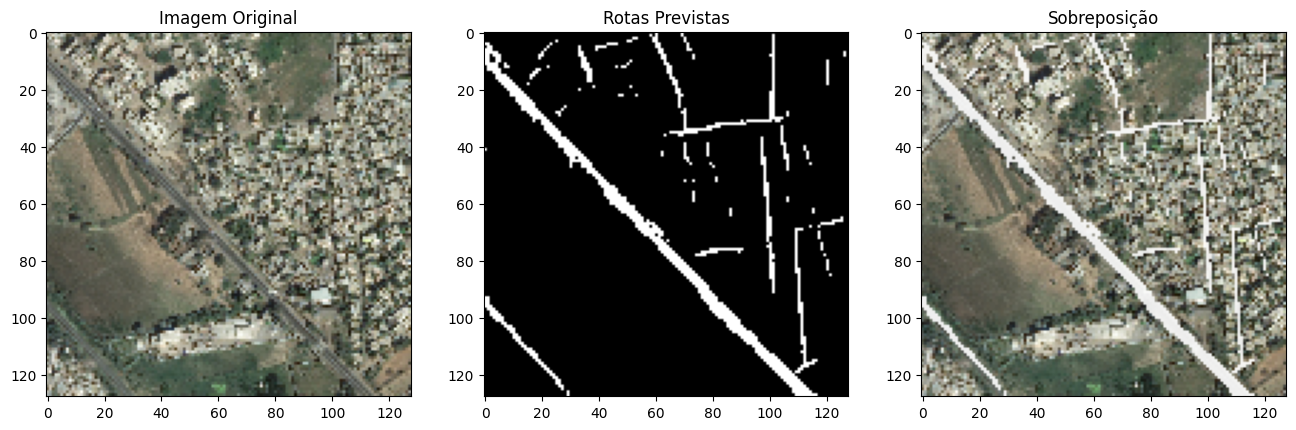

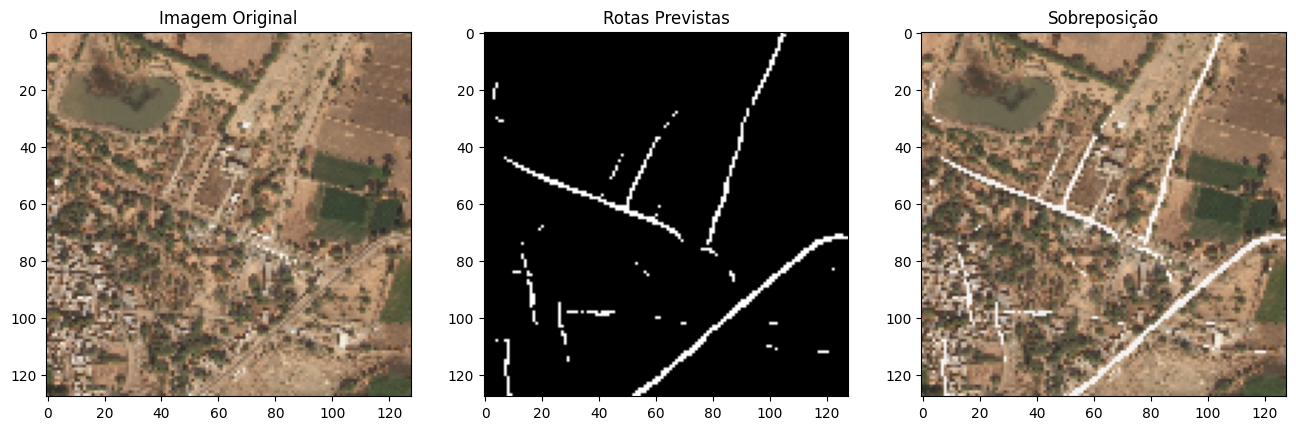

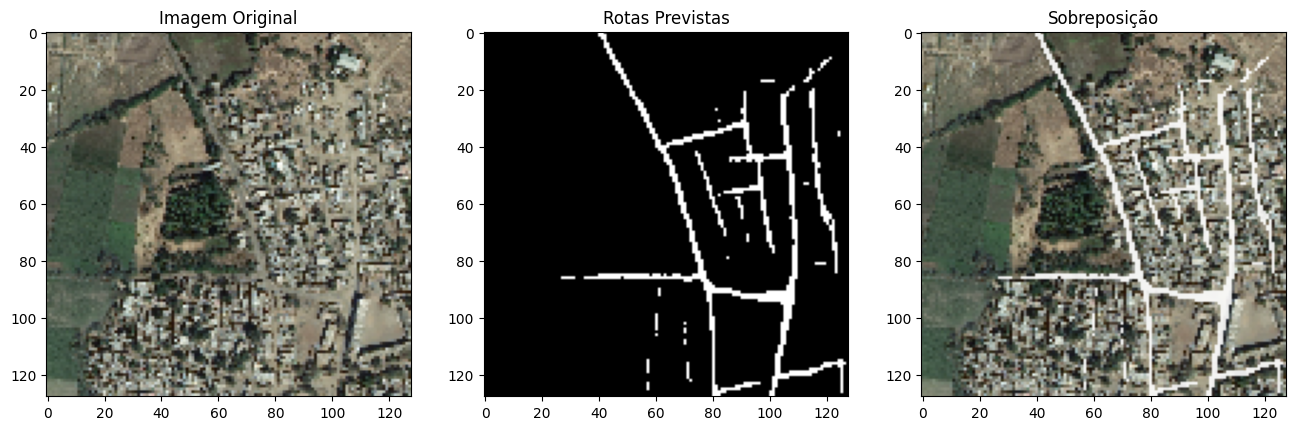

In [55]:
for _ in range(10):
  indice = np.random.randint(0, len(testImages))
  overlay_result = create_overlay(testImages[indice], test_predictions[indice])

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 3, 1)
  plt.imshow(testImages[indice])
  plt.title('Imagem Original')
  plt.subplot(1, 3, 2)
  plt.imshow(test_predictions[indice], cmap='gray')
  plt.title('Rotas Previstas')
  plt.subplot(1, 3, 3)
  plt.imshow(overlay_result)
  plt.title('Sobreposição')
  plt.show()